In [44]:
import pandas as pd
import random
import scipy as sp
import numpy as np
import cvxpy as cvx
import mosek
import matplotlib.pyplot as plt
import math

#### Load Data

In [45]:
dfTripData = pd.read_csv("location_data.csv")
dfLoadData=pd.read_csv("use_data_2wk.csv") #365 days, 1 min increment, 142 houses 
dfGenData=pd.read_csv("annual_capfac_15MinInterpolation.csv") #representative solar day, 15 min interval
dfAsPrices=pd.read_csv('20180701_20180701_PRC_AS_DAM_v1.csv')
dfCostElectric=pd.read_csv("TOU_Rate.csv") #15 min interal 4-9 pm, I think this is tou B

#### Script Parameters

In [46]:
intNumHouseNodes = 5
intNumCommNodes = 2
intTotalNodes = intNumHouseNodes + intNumCommNodes
intAvgNumCarsNode = 5 # goal is to have about 5 * 5 total cars
intSdNumCarsNode = 1
intProfiles = dfTripData.shape[0]

# could make battery parameters a randomized instantiation
fltCarEff = 3.95 # mi/kWh
fltBatteryCap = 40. # kWh
fltChargeRate = 1.9 # kW
fltDt = 0.25 # delta T
fltHomeRate = 7 # kW
fltWorkRate = 7 # kW

# time and conversion intervals
int_minutes=int(15)
int_run_days=2 # day
int_run_hours=24 # hours
int_run_time_interval=60/int_minutes #
time_kwh=15/60  # convert kw data to kwh


# cost to charge
lsCostElectric = []
for ind in range(int_run_days):
    for price in dfCostElectric.values:
        lsCostElectric.append(price)

#### Functions

In [47]:
# create residential nodes

def createCarsNodes(intNumHouseNodes, intNumCommNodes, intAvgNumCarsNode, intSdNumCarsNode, \
                    intProfiles, dfTripData):
    #initialize data frame to hold master
    dfNodesTrips = pd.DataFrame(columns=['TripId','ResNode','CommNode','HouseID'])  
    house=int(0)
    for intNode in range(intNumHouseNodes):

        # find how many vehicles will be at that residential node
        intNodeNumCars = int(random.gauss(intAvgNumCarsNode,intSdNumCarsNode))
        # assign cars to that node
        lsCarIds = [] # container to hold trip id for that node
        lsCommNode = [] # container to hold where the commerical node 
        lsResNode = [] # container to hold the res node
        lsVehicleHouses=[] #container to hold the house related to each vehicle/trip
        for intCar in range(intNodeNumCars):

            # find a car from the data frame
            ind = random.randint(0,intProfiles)
            lsCarIds.append(dfTripData['ID'].iloc[ind]) # add to car id container

            # save res node, added one because 1 initialized index was mismached with comm and load nodes
            lsResNode.append(intNode)  

            # find which commercial node that car goes to
            lsCommNode.append(random.randint(0,intNumCommNodes-1))
            
            #add a house id to associate with the trip id
            lsVehicleHouses.append(house)
            
            #iterate up house id, 0 based indexing to match the array calls/nodes
            house+=int(1)

        # create data frame and add to master
        dfNode = pd.DataFrame(list(zip(lsCarIds,lsResNode,lsCommNode,lsVehicleHouses)), \
                              columns=['TripId','ResNode','CommNode','HouseID'])

        dfNodesTrips = dfNodesTrips.append(dfNode)

    dfNodesTrips.reset_index(inplace=True, drop=True)
   
    intVeHouses=house
    
    return dfNodesTrips,intVeHouses
    

In [48]:

def convertLoadData(dfLoadData,dfNodesTrips,int_run_days,int_run_hours,int_minutes, intVeHouses,intNumCommNodes,intNumHouseNodes):
    '''
    process use data from 1 minute intervals to be on 15 minute interals and for specified run time, and associate with nodes and vehicles
    Each 24 hour time frame goes from 0 (midnight) to 24 (midnight)
    '''
    #initialize time frame to pull
    minutes=60*int_run_hours
    run_length=minutes*int_run_days
    intIntervals=int(run_length/int_minutes)
    
    #clean dataframe and convert to numpty for manipulation
    dfLoadData = dfLoadData.dropna(axis=1,thresh=100) #pull only nonzeros columns, but all of them have like one so just set a threshhold
    npLoadData=dfLoadData.to_numpy()
    run_loads=npLoadData[0:run_length,2:]    # run lenth extracted from dataset, 130+ loads included, skip timestep/day
    run_loads=run_loads.astype("float32")#I think iteration is faster in an np array? 
    #Initialize profile length to pull 
    intNumLoads = intVeHouses
    nLoads=len(run_loads[0,:]) 
   
    #container for house loads
    arrHouseLoads=np.zeros((intNumLoads, intIntervals))  #loadsxtime
    #process to 15 minutes fgor houses
    for n in range(intNumLoads):  
        random_select=random.randrange(0,nLoads,1)
        house_load_1min=run_loads[:,random_select] #1 house one vehicle
        o=int(0)
        j=0
        while o < (run_length-int_minutes): 
            start=o
            end=o+int_minutes
            new_interval=np.nanmean(house_load_1min[start:end])
            arrHouseLoads[n,j]=new_interval
            o+=int_minutes
            j+=1
            
    
    #calculate cumulative home nodes 
    dfNodeLoads=pd.DataFrame()  #rows will be t, columns will be node ID information, reverse of other df for easy lookup by node
    dctHomeNode=dict() #save node to id mapping, may be useful
    cumulativeLoads=np.zeros((intIntervals))
    i=0 #columns in the node dataframe
    
    for n in range(intNumHouseNodes):  
        #find all the houses that match that Node
        NodeID='ResNode'+str(n)
        lsHomeNode=dfNodesTrips[dfNodesTrips['ResNode']==int(n)].index.tolist()#all home/vehicles that have that resnode associated in dfNodesTrips
        sumrows=arrHouseLoads[lsHomeNode,:]
        cumulativeLoads=np.nansum(sumrows,axis=0)  #this should just be one column
        dctHomeNode[NodeID]=lsHomeNode
        dfNodeLoads.insert(i,NodeID,cumulativeLoads,True)
        i+=1
    
    arrCommercialLoads=np.zeros((intIntervals,intNumCommNodes))
    #commercial node loads, related to multiple vehicles 
    for k in range(intNumCommNodes):  #home x10 for commercial, should replace with real commercial values if possible! 
        random_select=random.randrange(0,nLoads,1)
        comm_load_1min=50*run_loads[:,random_select]
        o=int(0)
        j=0
        while o < (run_length-int_minutes): 
            start=o
            end=o+int_minutes
            new_interval=np.nanmean(comm_load_1min[start:end])
            arrCommercialLoads[j,k]=new_interval
            o+=int_minutes
            j+=1
        dfNodeLoads.insert(i,"CommNode"+str(k),arrCommercialLoads[:,k],True) 
        i+=1
    
    PeakTimes=dfNodeLoads.idxmax()
    PeakLoads=dfNodeLoads.max()

    
    lsNodes=dfNodeLoads.columns.values.tolist()
    return   arrHouseLoads,dfNodeLoads, PeakTimes,PeakLoads, lsNodes, dctHomeNode

In [49]:
def SolarGenData(dfGenData,int_run_days,int_run_hours,int_minutes,intVeHouses,intNumCommNodes,intNumHouseNodes, dctHomeNode):
    '''
    Process solar data to different solar capacities for each house (no commercial solar)
    '''
    #gendata is capfac at 15 minute intervals for 24 hours 
    run_schedule=int((60/int_minutes)*int_run_hours) #intervals
    intIntervals=int(run_schedule*int_run_days)
    intNumHomeSolar=intVeHouses
    #extract solar data
    npGenData=dfGenData.to_numpy() #I think iteration is faster in an np array?
    npGenData=npGenData[:,2]
    
    #initial house solar gen container 
    arrHouseGen=np.zeros((intNumHomeSolar,intIntervals))
    #every household must average 1 kw generation
    
    house_sol_scale=1 #kw
    comm_sol_scale=10 #kw
    #total solar gen for each house associated with a vehicle
    for n in range(intNumHomeSolar):
        for d in range(int_run_days):
            start=0
            end=start+run_schedule
            arrHouseGen[n,start:end]=np.multiply(npGenData[:],house_sol_scale)
    
    arrCommGen=np.zeros((intIntervals,intNumCommNodes))
    #node level generation
    dfNodeGens=pd.DataFrame()
    i=0
    for n in range(intNumHouseNodes):  
        NodeID='ResNode'+str(n)
        lsHomeNode=dctHomeNode[NodeID]
        sumrows=arrHouseGen[lsHomeNode,:]
    
        cumulativesolar=np.nansum(sumrows,axis=0)
        
        dfNodeGens.insert(i,NodeID,cumulativesolar,True)
        i+=1 
    for k in range(intNumCommNodes):  #home x10 for commercial, should replace with real commercial values! 
        for d in range(int_run_days):
            start=0
            end=start+run_schedule
            arrCommGen[start:end,k]=npGenData[:]*comm_sol_scale #5 house sum per node
        dfNodeGens.insert(i,"CommNode"+str(k),arrCommGen[:,k],True)
    i+=1
        
    return arrHouseGen,dfNodeGens,npGenData

In [50]:
def MapCarNodesTime(int_minutes,int_run_hours,lsVehicleHouses,dfNodesTrips,dfTripData):
    #make an array that has x vehicles by 96, with location ID, sum of total for each loc
    '''
    Function to find the maximum charging rate at each time interval and whether it is
    available to charge, and the node at which it is present 
    '''
   
    intervals=int((60/int_minutes)*int_run_hours) #intervals for one run
    intIntervals=int(intervals*int_run_days)
    intNumProfs=intVeHouses
    # this will hold the charging rate in kW
    arrChargeRate = np.zeros((intNumProfs, intervals)) 
    # this will hold the binary of whether the vehicle can charge
    arrCanCharge = np.zeros((intNumProfs, intervals))
    arrChargeLoc = np.empty((intNumProfs, intervals),dtype=object)
    arrHomeStation = np.empty((intNumProfs, intervals),dtype=object) # for stationary battery optimization
     
    for ind, strId in enumerate(dfNodesTrips['TripId']):

        # get location sequence for that trip
        lsLocations = dfTripData.loc[dfTripData['ID'] == strId].iloc[0,3:-1].values

        # iterate throught the locations to get its charge rate and availability 
        for intInterval, strLoc in enumerate(lsLocations):
            if strLoc == 'H': # if at home max charge 
                arrChargeRate[ind, intInterval] = fltHomeRate
                arrCanCharge[ind,intInterval] = 1
                arrChargeLoc[ind,intInterval]='ResNode'+str(dfNodesTrips.iloc[ind].loc['ResNode'])
            elif strLoc == 'W': # working charge rate
                arrChargeRate[ind, intInterval] = fltWorkRate
                arrChargeRate[ind,intInterval] = 1
                arrChargeLoc[ind,intInterval]='CommNode'+str(dfNodesTrips.iloc[ind].loc['CommNode'])
            else: # you are moving and can't charge
                arrChargeRate[ind, intInterval] = 0
                arrChargeRate[ind, intInterval] = 0
                arrChargeLoc[ind,intInterval]="Away"
            
            # just fill with residential node for stationary battery
            arrHomeStation[ind,intInterval] = 'ResNode'+str(dfNodesTrips.iloc[ind].loc['ResNode'])
    
    x=arrChargeRate
    y=arrCanCharge
    z=arrChargeLoc
    a = arrHomeStation                                                        
    for n in range(1,int_run_days):
        arrChargeRate=np.append(arrChargeRate,x,axis=1)
        arrCanCharge=np.append(arrCanCharge,y,axis=1)
        arrChargeLoc=np.append(arrChargeLoc,z,axis=1)
        arrHomeStation = np.append(arrHomeStation, a, axis=1)
                                                            
                   

    return arrChargeRate, arrCanCharge, arrChargeLoc, arrHomeStation
    

In [51]:
def netLoadChargeLoc(arrHouseGen,arrHouseLoads,arrChargeLoc,dfNodeLoads,dfNodeGens,\
                     intVeHouses,intTotalNodes,lsNodes,int_minutes,int_run_hours, arrHomeStation):
    '''
    Find the net kw at each charge pt locations
    '''
    intNumProfs=intVeHouses
    intervals=int(60/int_minutes*int_run_hours)
    intIntervals=int(intervals*int_run_days)
    arrNetNodeLoad=np.zeros((intTotalNodes,intIntervals))
    arrNetHomeLoad=np.zeros((intNumProfs,intIntervals))
    dfNetNodeLoad=pd.DataFrame()
    #use charge location as values to update to load value, ie charge location=column name, 
  
    #by house/vehicle net load & gen arrays now match for homes    
    arrNetHomeLoad=np.subtract(arrHouseLoads,arrHouseGen)
    
    #total net load per node; aggregated house gen/solar gen and commercial load/solar gen 
    dfNetNodeLoad=dfNodeLoads.subtract(dfNodeGens)
    
    NameDict={}
    dctNodeIdentity=dict()
    dctResIdentity = dict()
    
    #create identity arrays for the charge locations for each node at each timestep
    
    for n in lsNodes:
        
        # fill dictionary with identity
        name=n
        arrayOut=np.zeros((intNumProfs,intIntervals))
        for i in range(intIntervals):
            lsLoc=np.where(arrChargeLoc[:,i]==n)
            arrayOut[lsLoc,i]=1
        dctNodeIdentity[name]=arrayOut
        
        # if it's a residential node fill res identity dict
        arrRes = np.zeros((intNumProfs, intIntervals))
        if "Res" in name:
            lsCars = np.where(arrHomeStation[:,0] == name)
            arrRes[lsCars,:] = 1
        dctResIdentity[name] = arrRes
      
    return dfNetNodeLoad,arrNetHomeLoad,dctNodeIdentity, dctResIdentity

In [52]:
def findVehicleConsumption(dfNodesTrips, fltCarEff, fltDt, int_run_days):

    '''
    Function to find the power consumption of the vehicle at each time step
    from driving
    '''

    intNumProfs = dfNodesTrips.shape[0]
    arrConsumption = np.zeros((intNumProfs, 96))

    for ind, strId in enumerate(dfNodesTrips['TripId']):

        # find miles travelled
        fltMiles = dfTripData.loc[dfTripData['ID'] == strId,'DIST_M'].values[0]

        # get a list of locations
        lsLocations = dfTripData.loc[dfTripData['ID'] == strId].values.flatten()[3:-1].tolist()

        # so that we can find how many intervals we are away
        intAway = sum(1 if strLoc == "A" else 0 for strLoc in lsLocations)

        # miles per interval of travel and kwh per interval
        fltMiPerInt = fltMiles / intAway
        fltEnergyInt = fltMiPerInt / fltCarEff / fltDt # miles / (miles/kWh) / 0.25 hrs

        lsCarEnergy = [fltEnergyInt*-1 if strLoc == 'A' else 0 for strLoc in lsLocations ] 

        arrConsumption[ind,:] = lsCarEnergy
    
    # adjust for number of days of simulations
    arrConsumptionFinal = arrConsumption
    for ind in range(int_run_days-1):
        
        arrConsumptionFinal = np.hstack((arrConsumptionFinal, arrConsumption))
    
    return arrConsumptionFinal
    

In [53]:
def getSOCconstraints(dfNodesTrips, fltCarEff, fltChargeRate, fltDt,int_run_days):

    intNumProfs = dfNodesTrips.shape[0]
    arrSOCrequirements = np.zeros((intNumProfs, 96))
    
    ##this looks like its only treating each car like it has a single travel period, rather than multiple?
    for ind, strId in enumerate(dfNodesTrips['TripId']):

        # find miles travelled
        fltMiles = dfTripData.loc[dfTripData['ID'] == strId,'DIST_M'].values[0]

        # get a list of locations
        lsLocations = dfTripData.loc[dfTripData['ID'] == strId].values.flatten()[3:-1].tolist()

        # so that we can find how many intervals we are away
        intAway = sum(1 if strLoc == "A" else 0 for strLoc in lsLocations)

        # and then find the average miles travelled each interval
        fltAvgMileInterval = fltMiles / intAway

        intStart = 0 
        while intStart < 96 and 'A' in lsLocations[intStart:]:

            # Find the first first time we start moving
            intStart = intStart + lsLocations[intStart:].index('A') 

            # from there find when we arrive at a destination
            if 'W' in lsLocations[intStart:] and 'H' in lsLocations[intStart:]:
                intEnd = min(lsLocations[intStart:].index('H'), lsLocations[intStart:].index('W'))
            elif 'W' in lsLocations[intStart:]:
                intEnd = lsLocations[intStart:].index('W')
            elif 'H' in lsLocations[intStart:]:
                intEnd = lsLocations[intStart:].index('H')
            else: # we are going to assume they are driving the rest of the time??
                break
               

            # intervals driving for trip is then (intStart+intEnd +1) - intStart = intEnd =1
            # then we can find miles travelled for first trip 
            fltMilesTraveled = fltAvgMileInterval * (intEnd)
            fltKwhRequirement = fltMilesTraveled / fltCarEff # miles / (miles/kWh)

            # now find SOC required
            fltInitialSoc = fltKwhRequirement

            # so we need to to have the initial SOC at the interval before this time:
            arrSOCrequirements[ind,intStart-1] = fltInitialSoc
            
            # now let's back fill in SOC from there
            intNext = 2
            fltPreviousSOC = fltInitialSoc - fltChargeRate * fltDt
            while fltPreviousSOC > 0:
                
                # fill in the SOC needed in the previous time series
                arrSOCrequirements[ind, intStart - intNext] = fltPreviousSOC
                
                intNext += 1 # for next iteration go to the next previous time step
                fltPreviousSOC = fltPreviousSOC - fltChargeRate * fltDt
           

            intStart += intEnd # increment the starting point for finding the next trip
            
    # adjust final output for the length of the simulation
    arrSOCrequirementsFinal = arrSOCrequirements
    for ind in range(int_run_days-1):
        
        arrSOCrequirementsFinal = np.hstack((arrSOCrequirementsFinal, arrSOCrequirements))
    
    return arrSOCrequirementsFinal


In [54]:
def getChargeRateConstraints(dfNodesTrips, dfTripData):
    '''
    Function to find the maximum charging rate at each time interval and whether it is
    available to charge. 
    '''

    intNumProfs = dfNodesTrips.shape[0]
    # this will hold the charging rate in kW
    arrChargeRate = np.zeros((intNumProfs, 96)) 
    # this will hold the binary of whether the vehicle can charge
    arrCanCharge = np.zeros((intNumProfs, 96))
    

    for ind, strId in enumerate(dfNodesTrips['TripId']):

        # get location sequence for that trip
        lsLocations = dfTripData.loc[dfTripData['ID'] == strId].iloc[0,3:-1].values

        # iterate throught the locations to get its charge rate and availability 
        for intInterval, strLoc in enumerate(lsLocations):

            if strLoc == 'H': # if at home max charge 
                arrChargeRate[ind, intInterval] = fltHomeRate
                arrCanCharge[ind,intInterval] = 1
            elif strLoc == 'W': # working charge rate
                arrChargeRate[ind, intInterval] = fltWorkRate
                arrChargeRate[ind,intInterval] = 1
            else: # you are moving and can't charge
                arrChargeRate[ind, intInterval] = 0
                arrChargeRate[ind, intInterval] = 0
    
    return arrChargeRate, arrCanCharge

In [55]:
def getInitialSoc(arrSOCconstraint): 
    
    '''
    Function to get an random initialization of the vehicle's SOC
    '''
    
    intNumVehicles = np.shape(arrSOCconstraint)[0]
    lsInitialSoc = np.zeros((intNumVehicles)) # holder to have the initial SOC of vehicles

    for intVehicle in range(intNumVehicles): # for each vehicle 

        fltSocStart = random.random() * fltBatteryCap
        
        # make sure that the random SOC is > the minimum SOC required
        while fltSocStart < arrSOCconstraint[intVehicle,0]:
            fltSocStart = random.random() * fltBatteryCap
        
        lsInitialSoc[intVehicle] = fltSocStart
    
    # must START AND END at that SOC
    arrSOCconstraint[:,0] = lsInitialSoc
    arrSOCconstraint[:,-1] = lsInitialSoc
    
    return arrSOCconstraint

In [56]:
def getAsValues(dfAsPrices,int_run_days):
    dfAsPricesRu = dfAsPrices.loc[(dfAsPrices['ANC_REGION'] == 'AS_CAISO_EXP') \
                                    & (dfAsPrices['ANC_TYPE'] == 'RU')].sort_values('OPR_HR').reset_index()
    dfAsPricesRd = dfAsPrices.loc[(dfAsPrices['ANC_REGION'] == 'AS_CAISO_EXP') & \
                                  (dfAsPrices['ANC_TYPE'] == 'RD')].sort_values('OPR_HR').reset_index()

    lsRuValue = []
    lsRdValue = []

    for intHr in range(24):

        # get hourly $/MW price -- convert to 15 minute kWh
        fltUp = dfAsPricesRu['MW'].iloc[intHr]/1000 
        fltDown = dfAsPricesRd['MW'].iloc[intHr]/1000

        for intInterval in range(4):
            lsRuValue.append(fltUp)
            lsRdValue.append(fltDown)
    
    # adjust for simulation run period
    for ind in range(int_run_days-1):
        
        lsRdValue += lsRdValue
        lsRuValue += lsRuValue
    
    return lsRuValue, lsRdValue

#### Execute

In [57]:
def BatteryDegradationModel ():
    # dummy values -- MUST UPDATE
    #velvet->debugged, but wasnt sure intent on some of these, should this actually be part of a function that is called in the objective function?

    # battery constants
    fltAlphaSei = 5.75 * 10**-2
    fltBetaSei = 121
    fltKdelta1 = 1.40 * 10**5
    fltKdelta2 = -5.01 * 10**-1
    fltKdelta3= 1.23*10**5
    fltKsigma = 1.04
    fltSigmaRef = 0.5
    fltKtime = 4.14* 10**-10 # 1/s
    fltKtemp = 6.93 * 10**-2
    fltTref = 25 
    fltCost = 7000 # cost of Tesla battery replacement

    fltTemp=25
    fltDepthofDischarge=0.6
    fltStateofCharge=0.5
    fltTime=3600*int_run_hours # time in seconds


    fltStressTemp=math.exp(fltKtemp*(fltTemp-fltTref))*fltTref/fltTemp
    fltStressSOC=math.exp(fltKsigma*(fltStateofCharge-fltSigmaRef))
    #fltStressTime=fltKtime*fltTime  #not clear what t is supposed to be 
    fltStressDischarge=(fltKdelta1*fltDepthofDischarge**fltKdelta2+fltKdelta3)**(-1)

    fltDegradation=(fltStressDischarge)*fltStressSOC*fltStressTemp

    #varBatteryLife=fltAlphaSei*math.exp((-varNumberOfCycles*fltBetaSei*fltDegradation))+(1-fltAlphaSei)*math.exp((-varNumberOfCycles*fltDegradation))
    #need to double check the inputs 
        
    return fltAlphaSei,fltBetaSei,fltDegradation

In [58]:
# call functions to get Nodes Dataframe
dfNodesTrips, intVeHouses = createCarsNodes(intNumHouseNodes, intNumCommNodes, intAvgNumCarsNode, intSdNumCarsNode, \
                    intProfiles, dfTripData)

#create df of loads for commercial & residential nodes
arrHouseLoads,dfNodeLoads, PeakTimes,PeakLoads, lsNodes,dctHomeNode=convertLoadData(dfLoadData,dfNodesTrips, \
                                    int_run_days,int_run_hours,int_minutes, intVeHouses,intNumCommNodes,intNumHouseNodes)

#create generation for 15 min increments for each node
arrHouseGen,dfNodeGens,npGenData=SolarGenData(dfGenData,int_run_days,int_run_hours,int_minutes, \
                                              intVeHouses,intNumCommNodes,intNumHouseNodes, dctHomeNode)


# now call function to get the SOC constraints array
arrSOCconstraint = getSOCconstraints(dfNodesTrips, fltCarEff, fltChargeRate, fltDt, int_run_days)

# call function to get an array of maximum charging rates and map to location by node
arrChargeRate, arrCanCharge, arrChargeLoc, arrHomeStation =MapCarNodesTime(int_minutes,\
                                                            int_run_hours,intVeHouses,dfNodesTrips,dfTripData)


# call function to get initial SOCs of vehicles
# replaces first column of soc constraint array
arrSOCconstraint = getInitialSoc(arrSOCconstraint)  #should this have a different name?

# call function to get power consumption of the vehicle
arrConsumption = findVehicleConsumption(dfNodesTrips, fltCarEff, fltDt, int_run_days)

#Get Ancillarys service cost values 
lsRuValue, lsRdValue=getAsValues(dfAsPrices, int_run_days)

dfNetNodeLoad,arrNetHomeLoad, dctNodeIdentity, dctResIdentity = netLoadChargeLoc(arrHouseGen,arrHouseLoads,arrChargeLoc,dfNodeLoads,dfNodeGens,intVeHouses,\
                                              intTotalNodes,lsNodes,int_minutes,int_run_hours, arrHomeStation)

fltAlphaSei,fltBetaSei,fltDegradation = BatteryDegradationModel()


#### Define OptimizationFunctions

In [59]:
def make_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,dctNodeIdentity,lsNodes, \
                     arrConsumption,PeakLoads,intTotalNodes,dfNetNodeLoad,\
                     fltBatteryCap,fltDt,lsCostElectric,lsRdValue,lsRuValue,fltAlphaSei,fltBetaSei,fltDegradation):
    
    #I thought you couldn't use np functions inside cvx? may want to pass these in as variables instead
    # we could but this is fine. it's not within a cvx expression
    intVehicles = np.shape(arrSOCconstraint)[0]
    intTimes = np.shape(arrSOCconstraint)[1]
    
    # make variables
    varCharge = cvx.Variable((intVehicles,intTimes)) # charging rate of vehicles
    varDischarge = cvx.Variable((intVehicles,intTimes)) # discharging rate of vehicles
    varSOCs = cvx.Variable((intVehicles,intTimes)) # SOCs of the vehicles
    varBatteryLife=cvx.Variable((intVehicles)) #battery life of the vehicle remaining
    varNodeSum=cvx.Variable((intTotalNodes, intTimes))
    intVehicles = np.shape(arrSOCconstraint)[0]
    intTimes = np.shape(arrSOCconstraint)[1]
    # define regulation up and down variables
    varRegUp = cvx.Variable((np.shape(arrCanCharge))) #this array is # vehiclesxtimesteps
    varRegDown = cvx.Variable((np.shape(arrCanCharge)))
    varNumberOfCycles=cvx.Variable(intVehicles)
    varDegradationCost=cvx.Variable(intVehicles)
    #varDegradationCost=fltCost*(1-varBatteryLife)/0.2
    #varNumberOfCycles=(cvx.sum(varCharge, axis=1)-cvx.sum(varDischarge,axis=1))*fltDt/fltBatteryCap


    # initialzie constraints
    constraints = []
    
    # define the charge rate rate constraints
    constraints += [varCharge >= 0] # positively defined
    constraints += [varDischarge <= 0] # negatively defined
    constraints += [varSOCs >= 0] # can't have negative SOC
    constraints += [varSOCs <= fltBatteryCap] # can't over charge
    constraints += [varNodeSum>=0]
    constraints += [varRegUp >= 0]
    constraints += [varRegDown >= 0]
    constraints += [varDegradationCost>=0] #positively constrained 
    constraints += [varNumberOfCycles >= 0]


    
    #create node summation values for each vehicle at each time step to apply node level. I think this may need to be an intermediate variable that sums the vehicles together for the node?
    #Try out the identity matrix for each node*charge[v,t] array<transformer max[t] for each node!!
    
    for v in range(intVehicles):

        constraints += [varSOCs[v,0] == varSOCs[v,-1]]
        # loop through each time to model charging and SOC constraints
        for t in range(intTimes):
            
            # can only charge if present and max rate is given by array
            constraints += [varCharge[v, t] <= arrChargeRate[v,t]*arrCanCharge[v, t]]
            constraints += [-1*arrChargeRate[v,t]*arrCanCharge[v, t] <= varDischarge[v,t]]
            
            constraints += [varRegDown[v,t] <= (arrCanCharge[v,t]*arrChargeRate[v,t] - varCharge[v,t])]
            # or what is left to charge batteries capacity
            constraints += [varRegDown[v,t] <= ((fltBatteryCap - varSOCs[v,t])/fltDt - varCharge[v,t])]
            
            # reg up constraints 
            # it is at most the charge rate if it's avalable
            constraints += [varRegUp[v,t] <= (arrCanCharge[v,t]*arrChargeRate[v,t] + varDischarge[v,t])]
            # or what it's minimum SOC requriement is
            constraints += [varRegUp[v,t] <= ((varSOCs[v,t] - arrSOCconstraint[v,t])/fltDt + varDischarge[v,t])]
    
            
            # vehicle's SOC must be greater than the minimum requirement
            constraints += [varSOCs[v,t] >= arrSOCconstraint[v,t]]
            
                  
        for t in range(1,intTimes): # loop through from time 1 to end to set SOC
            
            constraints += [varSOCs[v,t]  == varSOCs[v,t-1] + varCharge[v,t]*fltDt + varDischarge[v,t]*fltDt + arrConsumption[v,t]*fltDt+varRegDown[v,t]*fltDt-varRegUp[v,t]*fltDt]
            
       # must end at the same SOC it started at --> CAN ALSO RESULT IN NEGATIVE OBJ VALUE
        
    
    for n, node in enumerate(lsNodes):
        
        # find the transformer size 
        TransformerMax=PeakLoads[node]*1.5  # max is 20% above max load
        # load has to be less than that 
        constraints+= [varNodeSum[n,:] <= TransformerMax]
        
        # gather node identities 
        arrNodeIdentities= dctNodeIdentity[node]
        for t in range (intTimes):
            constraints+= [varNodeSum[n,t] == cvx.sum(arrNodeIdentities[:,t]*(varCharge[:,t]+varDischarge[:,t]+varRegDown[:,t]-varRegUp[:,t]) + dfNetNodeLoad[node].iloc[t])]
            
    for v in range(intVehicles):
        constraints+= [varNumberOfCycles[v] >= (cvx.sum(varCharge[v,:]))*fltDt/fltBatteryCap]
        constraints+= [varNumberOfCycles[v] >= (cvx.sum(varCharge[v,:]) - \
                                     cvx.sum(varDischarge[v,:]))*fltDt/fltBatteryCap]
        constraints+= [varDegradationCost[v] >= 4.66*varNumberOfCycles[v]]
                        
   
    return constraints, varRegDown,varRegUp,varCharge,varDegradationCost
       
    

In [60]:
def make_objectives(constraints, varRegDown,varRegUp,varCharge,varDegradationCost,\
                    lsCostElectric,lsRdValue,lsRuValue):
    
        
    obj_value = cvx.sum(lsRdValue*cvx.sum(varRegDown,axis=0)) + \
                cvx.sum(lsRuValue*cvx.sum(varRegUp,axis=0)) - \
                cvx.sum(lsCostElectric*cvx.sum(varCharge,axis=0)) - \
               cvx.sum(varDegradationCost)
    
    return obj_value, varRegUp, varRegDown,varCharge

In [61]:
constraints, varRegDown,varRegUp,varCharge,varDegradationCost= make_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,dctNodeIdentity,lsNodes, \
                     arrConsumption,PeakLoads,intTotalNodes,dfNetNodeLoad,\
                     fltBatteryCap,fltDt,lsCostElectric,lsRdValue,lsRuValue,fltAlphaSei,fltBetaSei,fltDegradation)
obj_value, varRegUp, varRegDown, varCharge =  make_objectives(constraints, varRegDown,varRegUp,varCharge,varDegradationCost,\
                    lsCostElectric,lsRdValue,lsRuValue)
    
# convex usually needs to be minimized
obj = cvx.Maximize(obj_value)
prob = cvx.Problem(obj, constraints)

prob.solve(solver=cvx.MOSEK)



160.94633627892793

In [62]:
print(np.sum(varRegDown.value))
print(np.sum(varRegUp.value))
print(np.sum(varCharge.value))
print(np.sum(varDischarge.value))
print((obj.value))

15847.999999723866
15123.579341499371
0.0
None
160.94633627892796


Text(0.5, 1.0, 'Regulation Up Capacity')

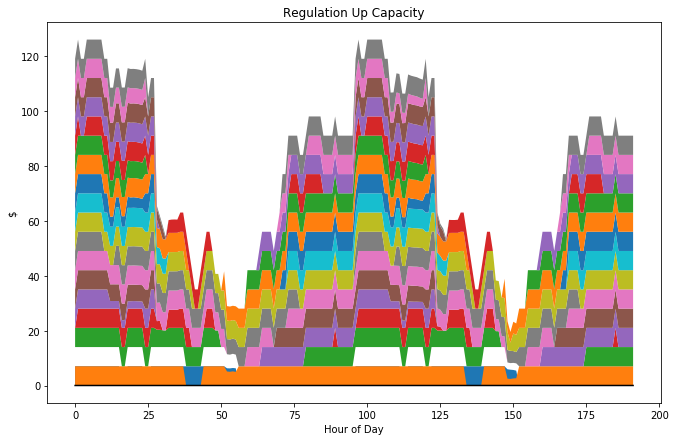

In [63]:
arrRegUp = varRegUp.value

fig, ax = plt.subplots(figsize=(11,7))
for ind in range(np.shape(arrRegUp)[1]):

    if ind == 1: 
        
        ax.fill_between(np.arange(96*2),np.zeros(96*2),np.array(arrRegUp[ind,:]).flatten())
    
    else: 
        
        lb = np.sum(arrRegUp[0:ind,:],axis=0)
        ub = np.sum(arrRegUp[0:ind+1,:],axis=0)
       
        ax.fill_between(np.arange(96*2),np.array(lb).flatten(),np.array(ub).flatten())

plt.plot(np.arange(96*2), lsRuValue,color='black')
plt.ylabel('$')
plt.xlabel("Hour of Day")
plt.title("Regulation Up Capacity")

[[7. 7. 7. ... 0. 0. 0.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 ...
 [7. 7. 7. ... 0. 0. 0.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]]


TypeError: 'NoneType' object is not subscriptable

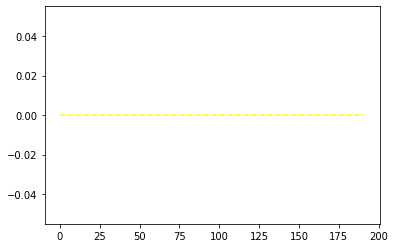

In [64]:

print(arrRegUp)
num_vehicles = np.shape(arrSOCconstraint)[0]
for v in range(num_vehicles):
    plt.figure()
#     plt.plot(np.arange(96),varCharge.value[v,:])
#     plt.plot(np.arange(96),arrConsumption[v,:])
    plt.plot(np.arange(96*int_run_days), varCharge.value[v,:], color='yellow', linestyle='--')
    plt.plot(np.arange(96*int_run_days), varDischarge.value[v,:], color='green', linestyle='--')
    plt.plot(np.arange(96*int_run_days), varRegUp.value[v,:], color='purple', linestyle='--')
    plt.plot(np.arange(96*int_run_days), varRegDown.value[v,:], color='blue', linestyle='--')
    plt.plot(np.arange(96*int_run_days), varSOCs.value[v,:], color='green',linestyle ='--')

#### Optimize for TOU only

#### How should we calculate the time difference between when the vehicle ends charging here compared to the case where they participate in AS with V2G? 

###### At the moment, this optimization results in very little charging because the travel demand is small compared to vehicle capacity.

In [ ]:
def make_tou_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,\
                     fltDt, fltBatteryCap, arrConsumption, PeakLoads,intTotalNodes, dfNetNodeLoad):
    

    intVehicles = np.shape(arrSOCconstraint)[0]
    intTimes = np.shape(arrSOCconstraint)[1]
    
    # make variables
    varCharge = cvx.Variable((intVehicles,intTimes)) # charging rate of vehicles
    # no need for discharge variable
    varSOCs = cvx.Variable((intVehicles,intTimes)) # SOCs of the vehicles
    varNodeSum = cvx.Variable((intTotalNodes, intTimes))
    
    # initialzie constraints
    constraints = []
    
    # define the charge rate rate constraints
    constraints += [varCharge >= 0] # positively defined
    constraints += [varSOCs >= 0] # can't have negative SOC
    constraints += [varSOCs <= fltBatteryCap] # can't over charge
    constraints += [varNodeSum >= 0]
      
    # define charging limits for each vehicle at each time
    for v in range(intVehicles):
        
      # loop through each time to model charging and SOC constraints
        for t in range(intTimes):
            
            # can only charge if present and max rate is given by array
            constraints += [varCharge[v, t] <= arrChargeRate[v,t]*arrCanCharge[v, t]]
            
            # vehicle's SOC must be greater than the minimum requirement
            constraints += [varSOCs[v,t] >= arrSOCconstraint[v,t]]
            
        # must end at the same SOC it started at 
        constraints += [varSOCs[v,0] == varSOCs[v,-1]]
        for t in range(1,intTimes): # loop through from time 1 to end to set SOC
            
            constraints += [varSOCs[v,t]  == varSOCs[v,t-1] + varCharge[v,t]*fltDt + arrConsumption[v,t]*fltDt]
    
    for n, node in enumerate(lsNodes):
        
        # find the transformer size 
        TransformerMax=PeakLoads[node]*1.5  #max is 20% above max load
        # load has to be less than that 
        constraints+= [varNodeSum[n,:] <= TransformerMax]
        
        # gather node identigies 
        arrNodeIdentities= dctNodeIdentity[node]
        for t in range (intTimes):
            constraints+= [varNodeSum[n,t] == cvx.sum(arrNodeIdentities[:,t]*varCharge[:,t]) + dfNetNodeLoad[node].iloc[t]]
        
    
    return constraints, varCharge, varSOCs
    

In [ ]:
def make_tou_objectives(constraints, varCharge,arrSOCconstraint,fltDt,lsCostElectric):
    
    
    intVehicles = np.shape(arrSOCconstraint)[0]
    intTimes = np.shape(arrSOCconstraint)[1]
    
    varCostToCharge = cvx.Variable(intTimes) # payments to charge vehicle
    varNumberOfCycles = cvx.Variable(intVehicles)
    varDegradationCost = cvx.Variable(intVehicles)
    
    constraints += [varDegradationCost >= 0] #positively constrained 
    constraints += [varNumberOfCycles >= 0]
    
    for v in range(intVehicles):
        constraints+= [varNumberOfCycles[v] == (cvx.sum(varCharge[v,:]))*fltDt/fltBatteryCap]
        constraints+= [varDegradationCost[v] == 4.66*varNumberOfCycles[v]]
     
    for t in range(intTimes):
        
        constraints += [varCostToCharge[t] == cvx.sum(varCharge[:,t])*lsCostElectric[t]*fltDt]

    obj_value = cvx.sum(varCostToCharge) + cvx.sum(varDegradationCost)
    
    return constraints, obj_value

In [ ]:
constraints, varCharge, varSOCs = make_tou_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,\
                                                fltDt, fltBatteryCap, arrConsumption,PeakLoads,intTotalNodes, dfNetNodeLoad)

constraints, obj_value = make_tou_objectives(constraints, varCharge,arrSOCconstraint,fltDt,lsCostElectric)

obj = cvx.Minimize(obj_value)
prob = cvx.Problem(obj, constraints)

prob.solve(solver=cvx.MOSEK)

In [ ]:
num_vehicles = np.shape(arrSOCconstraint)[0]
for v in range(num_vehicles):
    plt.figure()
#     plt.plot(np.arange(96),varCharge.value[v,:])
#     plt.plot(np.arange(96),arrConsumption[v,:])
    plt.plot(np.arange(96*int_run_days), arrSOCconstraint[v,:], color='orange', linestyle='--')
    plt.plot(np.arange(96*int_run_days), varSOCs.value[v,:], color='green',linestyle ='--')

#### Calculate the AS revenue if these were just stationary batteries

##### Are we going to compare total aggregate (not node based) AS capacity with vehcile to grid to this aggregated AS capacity?
###### Cannot directly compare node capacity since these batteries are moving? 

In [ ]:
def make_battery_constraints(fltWorkRate, fltDt, fltBatteryCap, intVehicles, intTimes, arrSOCconstraint, \
                             dctResIdentity,lsResNodes, dfNetNodeLoad):
    
    
    # make variables
    varCharge = cvx.Variable((intVehicles,intTimes)) # charging rate of vehicles
    varDischarge = cvx.Variable((intVehicles, intTimes)) # discharging rate of vehicles 
    varSOCs = cvx.Variable((intVehicles,intTimes)) # SOCs of the vehicles
    varNodeSum = cvx.Variable((len(lsResNodes), intTimes))
   
    # initialzie constraints
    constraints = []
    
    # define the charge rate rate constraints
    constraints += [0 <= varCharge]
    constraints += [varCharge <= fltWorkRate]
    constraints += [-1*fltWorkRate <= varDischarge]
    constraints += [varDischarge <= 0]
    constraints += [varSOCs >= 0] # can't have negative SOC
    constraints += [varSOCs <= fltBatteryCap] # can't over charge
 
    # SOC definition
    for v in range(intVehicles):
        
        # only specicify the inital SOC  has to equal end SOC
        constraints += [varSOCs[v,0] == varSOCs[v,-1]]
        
        for t in range(1,intTimes): # loop through from time 1 to end to set SOC

            constraints += [varSOCs[v,t]  == varSOCs[v,t-1] + varCharge[v,t]*fltDt + varDischarge[v,t]*fltDt]

    # residential node constraints        
    for n, node in enumerate(lsResNodes):
        
        # find the transformer size 
        TransformerMax=PeakLoads[node]*1.5  #max is 20% above max load
        # load has to be less than that 
        constraints+= [varNodeSum[n,:] <= TransformerMax]
        
        # gather node identities 
        arrNodeIdentities= dctResIdentity[node]
        for t in range (intTimes):
            constraints+= [varNodeSum[n,t] == cvx.sum(arrNodeIdentities[:,t]*varCharge[:,t])+ dfNetNodeLoad[node].iloc[t]]
    
    
    return constraints, varCharge, varDischarge, varSOCs
    

In [ ]:
def make_battery_objectives(constraints, varCharge, varDischarge, varSOCs, intVehicles, intTimes, \
                    fltBatteryCap,fltDt,lsCostElectric,lsRdValue,lsRuValue,
                    dctResIdentity):
    
    
    # define regulation up and down variables
    varRegUp = cvx.Variable((intVehicles, intTimes)) #this array is # vehiclesxtimesteps
    varRegDown = cvx.Variable((intVehicles, intTimes))
    varNumberOfCycles=cvx.Variable(intVehicles)
    varDegradationCost=cvx.Variable(intVehicles)

    # always positive
    constraints += [varRegUp >= 0]
    constraints += [varRegDown >= 0]
    constraints += [varNumberOfCycles >= 0]
    constraints += [varDegradationCost >= 0]
   
    for v in range(intVehicles):
#         constraints+= [varNumberOfCycles[v] >= (cvx.sum(varCharge[v,:]))*fltDt/fltBatteryCap]
        constraints+= [varNumberOfCycles[v] >= (cvx.sum(varCharge[v,:]) - \
                                     cvx.sum(varDischarge[v,:]))*fltDt/fltBatteryCap]
        constraints+= [varDegradationCost[v] >= 4.66*varNumberOfCycles[v]]
        

        for t in range(intTimes):
    
            # reg down constraints
            # it is at most the charging rate if it's available
            constraints += [varRegDown[v,t] <= (fltWorkRate - varCharge[v,t])*lsRdValue[t]]
            # or what is left to charge batteries capacity
            constraints += [varRegDown[v,t] <= ((fltBatteryCap - varSOCs[v,t])/fltDt - varCharge[v,t])*lsRdValue[t]]
            
            # reg up constraints 
            # it is at most the charge rate if it's avalable 
            constraints += [varRegUp[v,t] <= (fltWorkRate + varDischarge[v,t])*lsRuValue[t]]
            # or what it's minimum SOC requriement is
            constraints += [varRegUp[v,t] <= (varSOCs[v,t]/fltDt + varDischarge[v,t])*lsRuValue[t]]
    
    obj_value = cvx.sum(varRegDown) + \
                cvx.sum(varRegUp) - \
                cvx.sum(lsCostElectric*cvx.sum(varCharge,axis=0)) - \
               cvx.sum(varDegradationCost)
    
    return constraints, obj_value, varRegUp, varRegDown

In [ ]:
intVehicles = np.shape(arrChargeRate)[0]
intTimes = np.shape(arrChargeRate)[1]

lsResNodes = [strNode for strNode in lsNodes if "Res" in strNode]

constraints, varCharge, varDischarge, varSOCs= make_battery_constraints(fltWorkRate, fltDt, fltBatteryCap, intVehicles, intTimes, arrSOCconstraint, \
                             dctResIdentity, lsResNodes, dfNetNodeLoad)

constraints, obj_value, varRegUp, varRegDown = make_battery_objectives(constraints, varCharge, varDischarge, varSOCs, intVehicles, intTimes, \
                    fltBatteryCap,fltDt,lsCostElectric,lsRdValue,lsRuValue,
                    dctResIdentity)

obj = cvx.Maximize(obj_value)
prob = cvx.Problem(obj, constraints)


arrRegUp = varRegUp.value
arrRegDown = varRegDown.value
print('Done!')


In [ ]:
arrRegUp = varRegUp.value

fig, ax = plt.subplots(figsize=(11,7))
for ind in range(1,np.shape(arrRegUp)[1]):

    if ind == 1: 
        
        ax.fill_between(np.arange(96*2),np.zeros(96*2),np.array(arrRegUp[ind,:]).flatten())
    
    else: 
        
        lb = np.sum(arrRegUp[0:ind,:],axis=0)
        ub = np.sum(arrRegUp[0:ind+1,:],axis=0)
       
        ax.fill_between(np.arange(96*2),np.array(lb).flatten(),np.array(ub).flatten())

plt.plot(np.arange(96*2), lsRuValue,color='black')
plt.ylabel('$')
plt.xlabel("Hour of Day")
plt.title("Regulation Up Capacity")

In [ ]:
print(obj_value)


In [ ]:
varRegUp.value